In [1]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.ops as ops
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import os
from tqdm  import tqdm
from pycocotools.coco import COCO
import glob
import json
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop
import torchvision.transforms.v2  as transforms

In [2]:
if torch.cuda.is_available():
    print('CUDA is available!')
else:
    print('CUDA is not available.')

# Print the CUDA device count
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

# Get the current CUDA device
current_device = torch.cuda.current_device()
print(f"Current CUDA device: {current_device}")

# Print the name of the current CUDA device
print(f"Current CUDA device name: {torch.cuda.get_device_name(current_device)}")
torch.backends.cudnn.enabled = False

CUDA is available!
Number of CUDA devices: 1
Current CUDA device: 0
Current CUDA device name: NVIDIA GeForce RTX 4070


### Params

In [3]:
root_folder = 'tf_images'
ann_folder = 'tf_dset'
EPOCHS = 300
ES_START_EPOCH = 0
PATIENCE = 500
LR = 0.001

### Prepare Dataset

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root, ann_folder, class_list, transforms=None, update_paths=True):
        self.root = root
        self.transforms = transforms
        self.class_list = class_list
        self.update_paths = update_paths

        if update_paths:
            self.update_json_image_paths(ann_folder)

        self.dataset = []
        ann_files = glob.glob(os.path.join(ann_folder, "*.json"))
        for annFile in ann_files:
            with open(annFile, 'r') as f:
                data = json.load(f)
                self.dataset.append(data)
            print(f"Loaded {annFile} with {len(data['shapes'])} annotations")

        self.img_ids = [i for i in range(len(self.dataset))]
        print(f"Total unique image IDs: {len(self.img_ids)}")

    def __getitem__(self, idx):
        if idx >= len(self.img_ids):
            raise IndexError("Index out of range")


        img_id = self.img_ids[idx]
        original_width, original_height = self._get_original_image_size_from_json(img_id)
        img, target = self._load_image_and_annotations(img_id, original_width, original_height)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)

    def _load_image_and_annotations(self, img_id, original_width, original_height):
        data = self.dataset[img_id]

        img_path = os.path.join(self.root, os.path.basename(data['imagePath']))
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found")

        img = Image.open(img_path).convert("RGB")
        img = T.ToTensor()(img)

        boxes, labels = self._get_annotation_data_from_json(data['shapes'], original_width, original_height)
        masks = np.array(self.create_segmentation_masks((1024, 1024), boxes))

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "masks": torch.tensor(masks, dtype=torch.uint8),
        }

        return img, target
    
    def _get_original_image_size_from_json(self, img_id):
        data = self.dataset[img_id]
        return data['imageWidth'], data['imageHeight']

    def _get_annotation_data_from_json(self, shapes, original_width, original_height, target_size=1024):
        boxes = []
        labels = []

        for ann in shapes:
            points = ann['points']
            xmin = min(point[0] for point in points)
            ymin = min(point[1] for point in points)
            xmax = max(point[0] for point in points)
            ymax = max(point[1] for point in points)
            
            # Normalize bounding box coordinates based on original image size
            xmin_norm = xmin * target_size / original_width
            ymin_norm = ymin * target_size / original_height
            xmax_norm = xmax * target_size / original_width
            ymax_norm = ymax * target_size / original_height

            boxes.append([xmin_norm, ymin_norm, xmax_norm, ymax_norm])
            labels.append(self.class_list.index(ann['label']))

        return boxes, labels

    def create_segmentation_masks(self, image_size, boxes):
        masks = []
        for box in boxes:
            mask = Image.new('L', image_size, 0)
            draw = ImageDraw.Draw(mask)
            xmin, ymin, xmax, ymax = box
            polygon_coords = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
            draw.polygon(polygon_coords, fill=1)
            mask_np = np.array(mask)
            masks.append(mask_np)
        return masks

    def update_json_image_paths(self, ann_folder):
        json_files = glob.glob(os.path.join(ann_folder, '*.json'))

        def update_json_file(json_file):
            with open(json_file, 'r') as f:
                data = json.load(f)

            old_path = data['imagePath']
            image_basename = os.path.basename(old_path.replace('\\', '/'))
            new_path = os.path.join(self.root, image_basename)
            data['imagePath'] = new_path

            with open(json_file, 'w') as f:
                json.dump(data, f, indent=4)

        for json_file in json_files:
            update_json_file(json_file)
            print(f"Updated image paths in {json_file}")

        print("All JSON files updated successfully.")

In [5]:
class_list = [
    "__background__",
    "ad_unterschrift", "adress_aend", "ad_erzieher", "ad_neue_ad", "ad_schueler_unterschrift",
    "ad_erzieher_name", "ad_erzieher_vorname", "ad_erzieher_tel", "ad_erzieher_email",
    "ad_neue_ad_str_haus_nr", "ad_neue_ad_plz", "ad_neue_ad_stadt", "ad_schueler_datum",
    "schueler", "schueler_name", "schueler_vorname", "schueler_klasse",
    "ag", "ag_auswahl", "ag_unterschrift", "ag_schueler_datum",
    "ag_auswahl_wahl_1", "ag_auswahl_wahl_2", "ag_auswahl_wahl_3", "ag_schueler_unterschrift",
    "AL", "al_1", "al_2", "al_3", "allergien", "Sonstiges" ]

print(len(class_list))

transformz = T.Compose([T.ColorJitter(
                        brightness = (0.800, 1.2),
                        contrast = (0.5, 1.5),
                        saturation = (0.5, 1.5),
                        hue = (-0.05, 0.05),
                        ),
                        T.RandomGrayscale(),
                        T.Resize((1024, 1024)), ])

iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                            max_scale=1.0,
                            min_aspect_ratio=0.5,
                            max_aspect_ratio=2.0,
                            sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                            trials=400,
                            jitter_factor=0.25)

# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)
# Nathans Augmentations
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=1024)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([1024] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm,
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

32


In [6]:
# Create dataset instances
complete_dataset = CustomDataset(
    root_folder, ann_folder, class_list, transformz
)

# Check if the dataset is loaded correctly
print(f"Total number of samples: {len(complete_dataset)}")
for i in range(1):
    try:
        img, target = complete_dataset[i]
        print(f"Sample {i + 1}:")
        print(f" - Image shape: {img.shape}")
        print(f" - Number of boxes: {len(target['boxes'])}")
        print(f" - Boxes: {target['boxes']}")
        print(f" - Labels: {target['labels']}")
        print(f" - Masks shape: {target['masks'].shape}")
        print()
    except Exception as e:
        print(f"Error loading sample {i + 1}: {e}")

Updated image paths in tf_dset/AL_001.json
Updated image paths in tf_dset/AL_002.json
Updated image paths in tf_dset/AL_003.json
Updated image paths in tf_dset/AL_004.json
Updated image paths in tf_dset/AL_005.json
All JSON files updated successfully.
Loaded tf_dset/AL_001.json with 13 annotations
Loaded tf_dset/AL_002.json with 13 annotations
Loaded tf_dset/AL_003.json with 13 annotations
Loaded tf_dset/AL_004.json with 13 annotations
Loaded tf_dset/AL_005.json with 13 annotations
Total unique image IDs: 5
Total number of samples: 5
Loading image ID: 0
Sample 1:
 - Image shape: torch.Size([3, 1024, 1024])
 - Number of boxes: 13
 - Boxes: tensor([[190.4658, 475.0109, 765.4286, 510.0244],
        [173.3414, 506.3367, 765.9484, 541.5676],
        [185.6513, 537.6165, 768.3192, 574.4937],
        [165.1804, 622.6052, 765.7660, 661.2867],
        [163.8856, 653.6478, 764.4894, 692.3030],
        [165.1439, 686.9097, 765.6383, 722.0682],
        [167.7062, 720.1519, 765.4012, 752.5577],
   

In [7]:
# Define dataset lengths
train_size = int(0.6 * len(complete_dataset))
val_size = int(0.2 * len(complete_dataset))
test_size = len(complete_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(complete_dataset, [train_size, val_size, test_size])

# Define data loaders
train_data_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

val_data_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

test_data_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))

### Test Loaders

In [8]:
def plot_image(image, boxes, labels, masks, class_list=None):
    fig, ax = plt.subplots(1)
    image = image.permute(1, 2, 0).cpu().numpy()
    ax.imshow(image)

    for mask in masks:
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)
        masked_image = np.ma.masked_where(mask[0] == 0, mask[0])
        ax.imshow(masked_image, alpha=0.5, cmap='jet')

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=0.2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, class_list[label], fontsize=6, color='r')
    plt.axis('off')
    plt.show()

Testing train data loader...
Loading image ID: 2
Loading image ID: 0
Loading image ID: 1
Batch 1:
 - Number of images: 2
 - Image size: torch.Size([3, 1024, 1024])
 - Number of targets: 2
 - Target 1:
   - Boxes shape: torch.Size([13, 4])
   - Labels shape: torch.Size([13])
 - Mask shape: torch.Size([13, 1024, 1024])


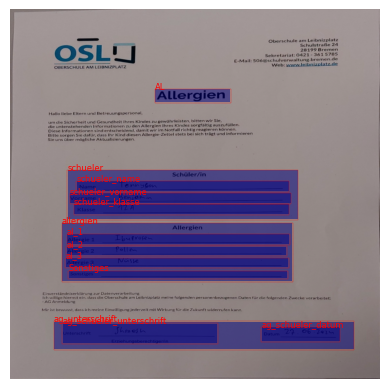

 - Target 2:
   - Boxes shape: torch.Size([13, 4])
   - Labels shape: torch.Size([13])
 - Mask shape: torch.Size([13, 1024, 1024])


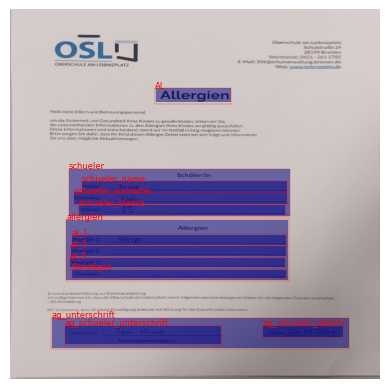

Testing validation data loader...
Loading image ID: 3
Batch 1:
 - Number of images: 1
 - Image size: torch.Size([3, 1024, 1024])
 - Number of targets: 1
 - Target 1:
   - Boxes shape: torch.Size([13, 4])
   - Labels shape: torch.Size([13])
 - Mask shape: torch.Size([13, 1024, 1024])


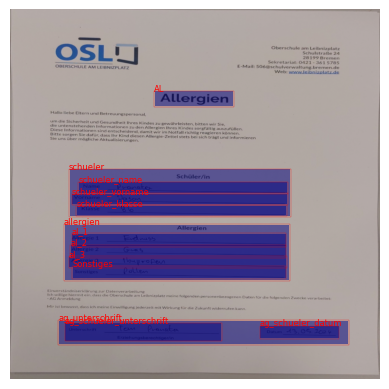

Testing test data loader...
Loading image ID: 4
Batch 1:
 - Number of images: 1
 - Image size: torch.Size([3, 1024, 1024])
 - Number of targets: 1
 - Target 1:
   - Boxes shape: torch.Size([13, 4])
   - Labels shape: torch.Size([13])
 - Mask shape: torch.Size([13, 1024, 1024])


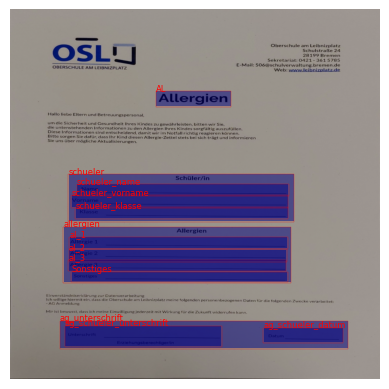

In [9]:
def test_loader(data_loader, name, class_list):
    print(f"Testing {name} data loader...")
    for i, (images, targets) in enumerate(data_loader):
        print(f"Batch {i + 1}:")
        print(f" - Number of images: {len(images)}")
        print(f" - Image size: {images[0].shape}")
        print(f" - Number of targets: {len(targets)}")
        for j in range(len(targets)):
            boxes = targets[j]['boxes']
            labels = targets[j]['labels']
            masks = targets[j]['masks']
            
            print(f" - Target {j + 1}:")
            print(f"   - Boxes shape: {boxes.shape}")
            print(f"   - Labels shape: {labels.shape}")
            print(f" - Mask shape: {targets[j]['masks'].shape}")
            
            plot_image(images[j], boxes, labels, masks, class_list)
        break

# Test each data loader
test_loader(train_data_loader, "train", class_list)
test_loader(val_data_loader, "validation", class_list)
test_loader(test_data_loader, "test", class_list)

### Early Stopping

In [10]:
class EarlyStopping:
    def __init__(self, patience=50, delta=0, verbose=False, start_epoch=0):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = float('inf')
        self.start_epoch = start_epoch

    def __call__(self, val_loss, model, epoch):
        if epoch < self.start_epoch:
            return

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), 'checkpoint.pth')
        self.best_loss = val_loss

### Evaluation Metrics

In [11]:
def compute_metrics(pred_boxes, pred_labels, pred_scores, pred_masks, true_boxes, true_labels, true_masks, iou_threshold=0.5):
    num_classes = np.max(np.concatenate([pred_labels, true_labels])) + 1
    tp = np.zeros(num_classes)
    fp = np.zeros(num_classes)
    fn = np.zeros(num_classes)
    matched = [[] for _ in range(num_classes)]

    for pred_box, pred_label, pred_mask in zip(pred_boxes, pred_labels, pred_masks):
        match_found = False
        for idx, (true_box, true_label, true_mask) in enumerate(zip(true_boxes, true_labels, true_masks)):
            if pred_label == true_label:
                box_iou = compute_box_iou(pred_box, true_box)
                mask_iou = compute_mask_iou(pred_mask, true_mask)
                
                if box_iou >= iou_threshold and mask_iou >= iou_threshold and idx not in matched[true_label]:
                    tp[true_label] += 1
                    matched[true_label].append(idx)
                    match_found = True
                    break
        if not match_found:
            fp[pred_label] += 1

    for idx, true_label in enumerate(true_labels):
        if idx not in matched[true_label]:
            fn[true_label] += 1

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) > 0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) > 0)
    accuracy = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp + fp + fn) > 0)
    ap = compute_ap(tp, fp, fn)
    mAP = np.mean(ap)

    return {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'mAP': mAP
    }

def compute_box_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    intersection_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

def compute_mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union
    return iou

def compute_ap(tp, fp, fn):
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) > 0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) > 0)
    ap = precision * recall
    return ap


In [12]:
class TrainingHistory:
    def __init__(self):
        self.losses = []
        self.precisions = []
        self.recalls = []
        self.accuracies = []
        self.mAPs = []

    def log_metrics(self, metrics_dict):
        self.losses.append(metrics_dict['val_loss'])
        self.precisions.append(metrics_dict['precision'])
        self.recalls.append(metrics_dict['recall'])
        self.accuracies.append(metrics_dict['accuracy'])
        self.mAPs.append(metrics_dict['mAP'])
    
    def get_history(self):
        return {
            'val_loss': self.losses,
            'precisions': self.precisions,
            'recalls': self.recalls,
            'accuracies': self.accuracies,
            'mAPs': self.mAPs
        }

### Training functions

In [13]:
def one_epoch(model, optimizer, data_loader, device, progress_bar):
    model.train()
    running_loss = 0.0
    bar = tqdm(data_loader, desc="Training", leave=False)
    for images, targets in bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        progress_bar.update(1)
    
    return running_loss / len(data_loader)

def evaluate(model, data_loader, device, progress_bar, iou_threshold=0.8, nms_threshold=0.8, plot = False):
    model.eval()
    metrics = {
        'precision': [],
        'recall': [],
        'accuracy': [],
        'mAP': []
    }
    running_val_loss = 0.0

    bar = tqdm(data_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, targets in bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                keep = []
                unique_labels = output['labels'].unique()
                for label in unique_labels:
                    class_mask = output['labels'] == label
                    boxes = output['boxes'][class_mask]
                    scores = output['scores'][class_mask]
                    class_keep = ops.nms(boxes, scores, nms_threshold)
                    keep.extend(class_keep.cpu().numpy())
                keep = torch.as_tensor(keep, dtype=torch.long, device=device)
                outputs[i] = {k: v[keep] for k, v in output.items()}
            model.train()
            loss_dict = model(images, targets)
            model.eval()

            if isinstance(loss_dict, dict):
                val_loss = sum(loss for loss in loss_dict.values()).item()
            else:
                val_loss = sum(loss for loss in loss_dict).item()
            
            running_val_loss += val_loss
            progress_bar.update(1)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_masks = output['masks'].cpu().numpy() > 0.5
                true_boxes = target['boxes'].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                true_masks = target['masks'].cpu().numpy() > 0.5
                
                metric = compute_metrics(pred_boxes, pred_labels, pred_scores, pred_masks,
                                        true_boxes, true_labels, true_masks, iou_threshold)
                metrics['precision'].append(metric['precision'])
                metrics['recall'].append(metric['recall'])
                metrics['accuracy'].append(metric['accuracy'])
                metrics['mAP'].append(metric['mAP'])
                
                if plot:
                    print("Predicted boxes, labels, and masks:")
                    plot_image(images[0], pred_boxes, pred_labels, pred_masks)
                    print("Ground truth boxes, labels, and masks:")
                    plot_image(images[0], true_boxes, true_labels, true_masks)

    max_classes = max(len(p) for p in metrics['precision'])
    precision_padded = [np.pad(p, (0, max_classes - len(p)), 'constant') for p in metrics['precision']]
    recall_padded = [np.pad(r, (0, max_classes - len(r)), 'constant') for r in metrics['recall']]
    accuracy_padded = [np.pad(a, (0, max_classes - len(a)), 'constant') for a in metrics['accuracy']]

    avg_precision = np.mean(np.stack(precision_padded), axis=0)
    avg_recall = np.mean(np.stack(recall_padded), axis=0)
    avg_accuracy = np.mean(np.stack(accuracy_padded), axis=0)
    avg_mAP = np.mean(metrics['mAP'])
    avg_val_loss = running_val_loss / len(data_loader)

    return avg_val_loss, avg_precision, avg_recall, avg_accuracy, avg_mAP

def main_training_loop(model, optimizer, scheduler, train_loader, val_loader, history, device, num_epochs, patience=PATIENCE, start_epoch=ES_START_EPOCH):
    early_stopping = EarlyStopping(patience=patience, verbose=True, start_epoch=start_epoch)

    # Calculate the total number of steps
    total_steps = num_epochs * (len(train_loader) + len(val_loader))

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}:")

            # Training phase
            train_loss = one_epoch(model, optimizer, train_loader, device, pbar)
            print("Train Loss: {:.4f}".format(train_loss))

            # Validation phase
            model.eval()
            val_loss, avg_precision, avg_recall, avg_accuracy, avg_mAP = evaluate(model, val_loader, device, pbar)
            history.log_metrics({"val_loss": val_loss, "precision": avg_precision, "recall": avg_recall, "accuracy": avg_accuracy, "mAP": avg_mAP})
            print("Validation Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}, mAP: {:.4f}".format(
                val_loss,
                np.mean(avg_precision),
                np.mean(avg_recall),
                np.mean(avg_accuracy),
                avg_mAP
            ))
            if scheduler is not None:
                scheduler.step(val_loss)
            # Check early stopping
            early_stopping(val_loss, model, epoch)

            if early_stopping.early_stop:
                print("Early stopping: No improvement in the last {} epochs".format(patience))
                break
    model.load_state_dict(torch.load('checkpoint.pth'))
    torch.save(model.state_dict(), 'best_model.pth')
    print("Training completed!")

### Load and adjust untrained Mask R-CNN

In [14]:
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
num_classes = len(class_list)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, dim_reduced, num_classes)

device = torch.device("cuda")
model.to(device)
history = TrainingHistory()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.0005) # SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=LR, 
                                                total_steps=EPOCHS*len(train_data_loader))

In [15]:
main_training_loop(model, optimizer, None, train_data_loader, val_data_loader, history, device, num_epochs=EPOCHS)

Training Progress:   0%|          | 0/900 [00:00<?, ?it/s]


Epoch 1/300:


Loading image ID: 1
Loading image ID: 0
Loading image ID: 2


Training Progress:   0%|          | 2/900 [00:01<12:27,  1.20it/s]

Train Loss: 6.3940


Loading image ID: 3


Training Progress:   0%|          | 3/900 [00:02<12:02,  1.24it/s]

Validation Loss: 4.4399, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000, mAP: 0.0000
Validation loss decreased (inf --> 4.439869).  Saving model ...

Epoch 2/300:


Loading image ID: 2Loading image ID: 0

Loading image ID: 1


Training Progress:   1%|          | 5/900 [00:05<14:32,  1.03it/s]

Train Loss: 4.0078


Loading image ID: 3


Training Progress:   1%|          | 6/900 [00:05<13:02,  1.14it/s]

Validation Loss: 3.3363, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000, mAP: 0.0000
Validation loss decreased (4.439869 --> 3.336274).  Saving model ...

Epoch 3/300:


Loading image ID: 1
Loading image ID: 0
Loading image ID: 2


Training Progress:   1%|          | 8/900 [00:08<14:42,  1.01it/s]

Train Loss: 2.8154


Loading image ID: 3


Training Progress:   1%|          | 9/900 [00:08<13:01,  1.14it/s]

Validation Loss: 2.5518, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000, mAP: 0.0000
Validation loss decreased (3.336274 --> 2.551778).  Saving model ...

Epoch 4/300:


Loading image ID: 2Loading image ID: 1

Loading image ID: 0


Training Progress:   1%|          | 11/900 [00:11<14:36,  1.01it/s]

Train Loss: 2.3384


Loading image ID: 3


Training Progress:   1%|▏         | 12/900 [00:12<13:07,  1.13it/s]

Validation Loss: 2.2225, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000, mAP: 0.0000
Validation loss decreased (2.551778 --> 2.222499).  Saving model ...

Epoch 5/300:


Loading image ID: 0Loading image ID: 2

Loading image ID: 1


Training Progress:   1%|▏         | 13/900 [00:14<18:23,  1.24s/it]

In [ ]:
def plot_training_history(history_dict):
    epochs = range(1, len(history_dict['val_loss']) + 1)
    best_val_loss = min(history_dict['val_loss'])
    best_val_loss_idx = history_dict['val_loss'].index(best_val_loss)
    best_map = max(history_dict['mAPs'])
    best_map_idx = history_dict['mAPs'].index(best_map)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history_dict['val_loss'], label='Loss')
    plt.title('Validation Loss: {:.4f} Epoch: {}'.format(best_val_loss, best_val_loss_idx))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history_dict['mAPs'], label='mAP')
    plt.title('Mean Average Precision (mAP): {:.4f} Epoch: {}'.format(best_map, best_map_idx))
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    plt.legend()

    plt.tight_layout()
    plt.show()
history_dict = history.get_history()
plot_training_history(history_dict)

### Test Inference

In [ ]:
model_state_dict = torch.load('best_model.pth')
model = maskrcnn_resnet50_fpn_v2()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, dim_reduced, num_classes)
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()  # Set the model to evaluation mode

In [ ]:
for images, targets in test_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(images)
    for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].detach().cpu().numpy()
                pred_labels = output['labels'].detach().cpu().numpy()
                pred_scores = output['scores'].detach().cpu().numpy()
                pred_masks = output['masks'].detach().cpu().numpy() > 0.5
                true_boxes = target['boxes'].detach().cpu().numpy()
                true_labels = target['labels'].detach().cpu().numpy()
                true_masks = target['masks'].detach().cpu().numpy() > 0.5
                print("Predicted boxes, labels, and masks:")
                plot_image(images[0], pred_boxes, pred_labels, pred_masks, class_list)
                print("Ground truth boxes, labels, and masks:")
                plot_image(images[0], true_boxes, true_labels, true_masks, class_list)

In [ ]:
image = cv2.imread("/mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/tempimages_api/beispiel_form_covered.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = T.ToTensor()(image)
image = T.Resize((1024, 1024))(image)
image = image.unsqueeze(0).to(device)
with torch.no_grad():
    outputs = model(image)
pred_boxes = output['boxes'].detach().cpu().numpy()
pred_labels = output['labels'].detach().cpu().numpy()
pred_scores = output['scores'].detach().cpu().numpy()
pred_masks = output['masks'].detach().cpu().numpy() > 0.5
image = image.squeeze(0).cpu()
plot_image(image, pred_boxes, pred_labels, pred_masks, class_list)